In [1]:
%matplotlib inline

from functools import partial
from typing import *

import numpy as np
import scipy as sp   # scipy is a popular scientific computing library for Python
import scipy.stats   # statistics package
import matplotlib.pyplot as plt

# Lec 04: Gaussian Processes and Linear Regression

## Goal

1. The goal today is to introduce our first **non-linear** regression model, a Gaussian Process (GP).
2. GPs are a fundamental probabilistic regression model and have applications in scientific regression, Bayesian optimization.
3. Under certain conditions, GPs can also be shown to be equivalent to neural networks powering deep learning.
4. Along the way of introducing the GP model, we will need to introduce more probability and linear algebra.

## Outline 

1. Vector space of random variables
2. Linearity of expectation
3. Aside: Monte Carlo expectation
4. Multivariate Normal Distribution
    - Covariance Matrix
    - Hermitian + PSD matrix
    - Cholesky Decomposition
    - PDF + determinant
    - Correlation
    - Marginals
    - Conditionals
5. Gaussian Process Regression

## More Probability

### 1 Random Variable Summary


| Concept          | X Discrete   | X Continuous |
| -----------------| -----------  | ------------ |
| Mass/Density     | pmf $p_X(x)$ | pdf $p_X(x)$ |
| CDF $F_X(c)$     | $$\sum_{x \leq c} p(x)$$ | $$\int_{\infty}^c p(x) dx $$ |
| cdf vs. pmf/pdf  | $$p_X(c) = F_X(c) - F_X(c-1)$$ | $$\frac{d}{dx}F_X(c) = p_X(c)$$ |
| Probability      | probability of x is $$p_X(x)$$ | probability of interval $(a, b)$ is $F_X(b) - F_X(a)$ |
| Expectation $$\mathbb{E}(X)$$   | $$\sum_{x \in \mathcal{X}} x p_X(x)$$ | $$\int_{-\infty}^\infty x p_X(x) dx$$ |

### 2 Random Variables Summary

| Concept          | X, Y Discrete   | X,Y Continuous |
| -----------------| --------------  | -------------- |
| Joint pmf/pdf    | pmf $p_{X, Y}(x, y)$  | pdf $p_{X, Y}(x, y)$ |
| Marginal of X    | $$p_X(x) = \sum_{y \in \mathcal{Y}} p_{X, Y}(x, y)$$ | $$p_X(x) = \int_{-\infty}^\infty p_{X, Y}(x, y) dy$$|
| Marginal of Y    | $$p_Y(x) = \sum_{x \in \mathcal{X}} p_{X, Y}(x, y)$$ | $$p_Y(y) = \int_{-\infty}^\infty p_{X, Y}(x, y) dx$$|
| Conditional X given Y | conditional mass $p(x | y)$ | conditional density $p(x | y)$ | 
| Conditional Y given X | conditional mass $p(y | x)$ | conditional density $p(y | x)$ | 
| Factorizing distribution | $p(x, y) = p(y | x)p(x) = p(x | y)p(y)$ | $p(x, y) = p(y | x)p(x) = p(x | y)p(y)$ |

The situation with two random variables can be generalized to settings with $N$ random variables.

### Random variables can be made into a vector space

1. We need to define a $+$.
2. We need to define a scaling $\cdot$.

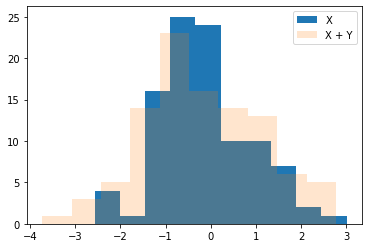

In [2]:
X = sp.stats.norm(loc=0.0, scale=1.0).rvs(size=100) # The random variable X
Y = sp.stats.norm(loc=0.0, scale=1.0).rvs(size=100) # The random variable Y
X_plus_Y = X + Y        # The random variable X + Y
                        # Add the random value in X with the random value in Y
plt.hist(X, label='X')
plt.hist(X_plus_Y, alpha=0.2, label='X + Y')
plt.legend()

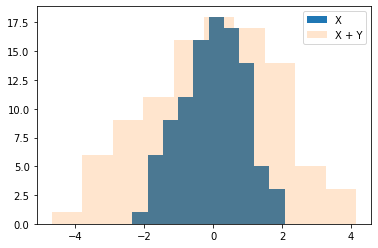

In [3]:
X = sp.stats.norm(loc=0.0, scale=1.0).rvs(size=100) # The random variable X
Y = X                   # Note, we can also create a random variable that is identically X
X_plus_Y = X + Y        # The random variable X + Y
                        # Add the random value in X with the random value in Y
plt.hist(X, label='X')
plt.hist(X_plus_Y, alpha=0.2, label='X + Y')
plt.legend()

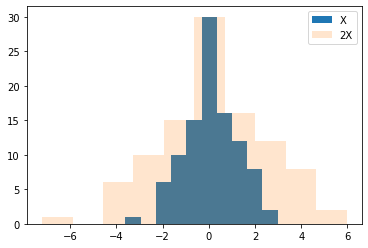

In [4]:
X = sp.stats.norm(loc=0.0, scale=1.0).rvs(size=100) # The random variable X
scale_X = 2.*X          # The random variable 2X
plt.hist(X, label='X')
plt.hist(scale_X, alpha=0.2, label='2X')
plt.legend()

### Definition: Vector Space of Random Variables

1. Let $V$ be the set of continuous random variables.
2. Suppose $X$ and $Y$ are continuous random variables. Then $X + Y$ is a continuous random variable which is a random variable that is the result of adding the random value in $X$ and the random value in $Y$. This statement can be made precise with measure theory.
3. Suppose $X$ is a continuous random variable. Then $c \cdot X$ is a continuous random variable which is the result of scaling the random value of $X$ by $c$.

This tuple $(V, +, \cdot)$ is a vector space after routine check of the axioms.

### Property: Linearity of Expectation

Recall that a function $f: V \rightarrow W$ between two vector spaces $V$ and $W$ was linear if
1. $f(c x) = c f(x)$ and
2. $f(x + y) = f(x) + f(y)$.

In the same way, expectation is a **linear functional**. A functional is a mapping $V \rightarrow \mathbb{R}$ where $V$ is some vector space. In this case, $V$ is a space of random variables.
1. $\mathbb{E}(cX) = c \mathbb{E}(X)$.
2. $\mathbb{E}(X + Y) = \mathbb{E}(X) + \mathbb{E}(Y)$

### Checking Linearity of Expectation

Suppose that $X$ is a continuous random variable.

\begin{align*}
\mathbb{E}(cX) & = \int_{-\infty}^\infty cx p_X(x) dx \tag{definition} \\
& = c \int_{-\infty}^\infty x p_X(x) dx \tag{integral property} \\
& = c \mathbb{E}(X) \tag{definition} \\
\end{align*}

Suppose that $X$ and $Y$ are two continuous random variables, not necessarily independent.

\begin{align*}
\mathbb{E}(X + Y) & = \int_{-\infty}^\infty \int_{-\infty}^\infty (x + y) p_{X, Y}(x, y) dx dy  \tag{definition} \\
& = \int_{-\infty}^\infty \int_{-\infty}^\infty x p_{X, Y}(x, y) dx dy + \int_{-\infty}^\infty \int_{-\infty}^\infty y p_{X, Y}(x, y) dx dy  \tag{distribute} \\
& = \int_{-\infty}^\infty \int_{-\infty}^\infty x p_{X, Y}(x, y) dy dx + \int_{-\infty}^\infty \int_{-\infty}^\infty y p_{X, Y}(x, y) dx dy  \tag{Fubini} \\
& = \int_{-\infty}^\infty x p_{X}(x) dx + \int_{-\infty}^\infty y p_{X, Y}(x, y) dy \tag{marginal} \\
& = \mathbb{E}(X) + \mathbb{E}(Y) \tag{definition} \\
\end{align*}

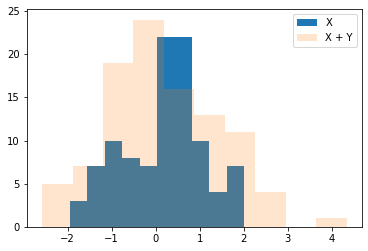

In [5]:
X = sp.stats.norm(loc=0.0, scale=1.0).rvs(size=100) # The random variable X
Y = sp.stats.norm(loc=0.0, scale=1.0).rvs(size=100) # The random variable Y
X_plus_Y = X + Y        # The random variable X + Y
                        # Add the random value in X with the random value in Y
plt.hist(X, label='X')
plt.hist(X_plus_Y, alpha=0.2, label='X + Y')
plt.legend()

### Aside: Monte Carlo Expectation

- How might we make an expectation computational?
- In particular, what if we don't know how to evaluate the integrals?
- We can use a computational method called **Monte Carlo** integration which approximates the integral.

$$
\mathbb{E}(f(X)) \approx \frac{1}{N}\sum_{i=1}^N f(x_i)
$$
where each $x_i$ is drawn **indendently and identically** (iid) from the distribution $F_X(c)$ and $f$ is some arbitrary function.

In [6]:
def monte_carlo_expectation(dist, N, f):
    Xs = dist.rvs(size=N)
    Xs = np.array([f(x) for x in Xs])
    return Xs.sum() / N

dist = sp.stats.norm(loc=0.0, scale=1.0)        # Creating a normal distribution centered at 0
monte_carlo_expectation(dist, 100, lambda x: x) # Expecting somewhere around 0.0

-0.02662833497267644

Text(0.5, 1.0, 'Behavior of Monte Carlo Expectation as a Function of N')

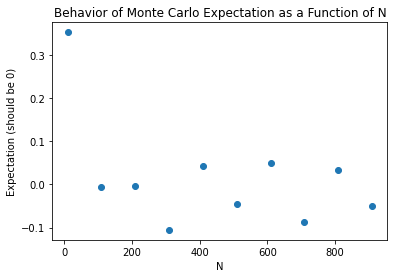

In [7]:
es = [monte_carlo_expectation(sp.stats.norm(loc=0, scale=1.0), N, lambda x: x) for N in range(10, 1010, 100)]
plt.scatter(range(10, 1010, 100), es)
plt.xlabel('N')
plt.ylabel('Expectation (should be 0)')
plt.title('Behavior of Monte Carlo Expectation as a Function of N')

Text(0.5, 1.0, 'Behavior of Monte Carlo Expectation as a Function of scale')

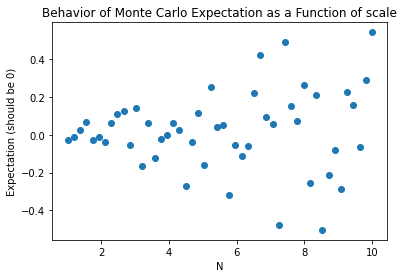

In [8]:
es = [monte_carlo_expectation(sp.stats.norm(loc=0, scale=scale), 1000, lambda x: x) for scale in np.linspace(1.0, 10.0)]
plt.scatter(np.linspace(1.0, 10.0), es)
plt.xlabel('N')
plt.ylabel('Expectation (should be 0)')
plt.title('Behavior of Monte Carlo Expectation as a Function of scale')

### Summary

You may have observed that the Monte Carlo estimate is affected by at least two factors.
1. First, larger $N$ decreases the spread between how far the estimate is away from its true value.
2. Second, the larger the scale of normal distribution, the larger the spread between the estimate and its true value.

This notion of "spread" is captured mathematically with the concept of **variance**.

### Definition: Variance

The variance is defined as below and captures the deviation of a random variable from it's mean.

\begin{align*}
Var(X) & = \mathbb{E}(X - \mathbb{E}(X))^2 \tag{definition} \\
& = \mathbb{E}(X^2 - 2X\mathbb{E}(X) + (\mathbb{E}(X))^2) \tag{distributivity} \\
& = \mathbb{E}(X^2) - 2\mathbb{E}(X)\mathbb{E}(X) + \mathbb{E}(X))^2 \tag{linearity of expectation} \\
& = \mathbb{E}(X^2) - \mathbb{E}(X)^2 \tag{simplification}
\end{align*}

Text(0.5, 1.0, 'Variance of Normal Distribution')

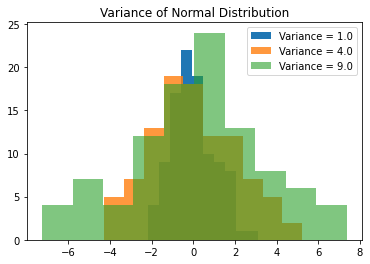

In [9]:
plt.hist(sp.stats.norm(loc=0.0, scale=1.0).rvs(size=100), label='Variance = 1.0')
plt.hist(sp.stats.norm(loc=0.0, scale=2.0).rvs(size=100), label='Variance = 4.0', alpha=0.8)
plt.hist(sp.stats.norm(loc=0.0, scale=3.0).rvs(size=100), label='Variance = 9.0', alpha=0.6)
plt.legend()
plt.title('Variance of Normal Distribution')

In [10]:
def estimate_variance(dist, N):
    second_moment = monte_carlo_expectation(dist, N, lambda x: x**2)
    mean_squared = monte_carlo_expectation(dist, N, lambda x: x)**2
    return second_moment - mean_squared

# Monte carlo estimate of variance of normal distribution
dist = sp.stats.norm(loc=0.0, scale=1.0)
estimate_variance(dist, 1000)

1.0814331331691147

#### Property: Variance is not linear

\begin{align*}
Var(aX) & = \mathbb{E}((aX)^2) - \mathbb{E}(aX)^2 \tag{definition} \\
& = a^2\mathbb{E}(X^2) - a^2\mathbb{E}(X)^2 \tag{linearity of expectation} \\
& = a^2 Var(x) \tag{simplification}
\end{align*}

### Summary

1. The idea of expectation is key to probability and machine learning.
2. Importantly, expectation is linear!
3. Expectation can be estimated numerically with Monte Carlo integration with some error.
4. Concepts such as variance are built out of expectation.
5. Variance is not linear!

## Multivariate Normal Distribution

1. A multi-dimensional generalization of the normal distribution.
2. A very important multi-dimensional distribution to understand as it is used extensively in probabilistic machine learning.
3. It contains many ideas from linear algebra and probability that we will try to highlight.
4. If I had to choose one probability distribution to study, it would be this one.

### Definition: Multivariate Normal Distribution

A **multivariate normal** distribution is notated $\mathcal{N}(\mu, \Sigma)$, and is parameterized by a $D$-dimensional mean vector $\mu$ and a $D \times D$ **covariance matrix** $\Sigma$. We'll introduce covariance matrices shortly, but let's start with a sampling view.

$$
X \sim \mathcal{N}(\mu, \Sigma)
$$
where produces $X$ which is a $D$-dimensional random vector.

In [11]:
# mean at 0, 0
D = 2
mu = np.zeros(D)
# let's use a 2x2 identity matrix as a covariance matrix
sigma = np.eye(D)
# 2-D multivariate normal
mvnorm = scipy.stats.multivariate_normal(mean=mu, cov=sigma)
# 2-D samples
mvnorm.rvs()

array([0.62285041, 1.08359208])

Text(0.5, 1.0, 'Samples from a Multivariate Normal')

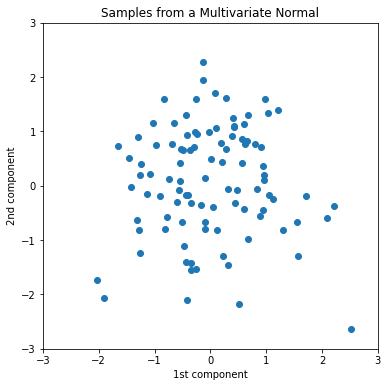

In [12]:
Xs = mvnorm.rvs(size=100)
fig = plt.figure(figsize=(6,6))
plt.scatter(Xs[:,0], Xs[:, 1])
plt.xlim(-3, 3); plt.ylim(-3, 3)
plt.xlabel('1st component'); plt.ylabel('2nd component');
plt.title('Samples from a Multivariate Normal')

#### Definition: Sample Mean

Suppose we have $N$ samples from a multivariate normal distribution $X_i$.
The **sample mean** is defined as
$$
\bar{\mu} = \frac{1}{N} \sum_{i=1}^N X_i
$$

In [13]:
def sample_mean(X: np.ndarray) -> np.ndarray:
    return X.mean(axis=0)

print("Actual mean", mu)
print("Sample mean", sample_mean(Xs))

Actual mean [0. 0.]
Sample mean [-0.02116475  0.11898407]


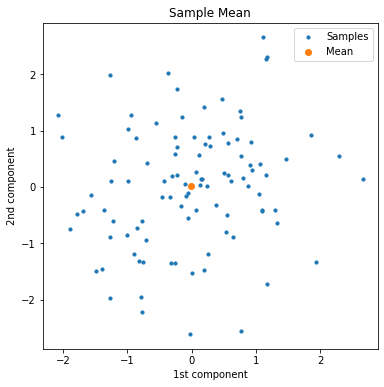

In [14]:
# Draw samples
Xs = mvnorm.rvs(size=100)
fig = plt.figure(figsize=(6,6))
# Plot samples
plt.scatter(Xs[:,0], Xs[:, 1], label='Samples', s=10)
# Plot mean
plt.scatter([sample_mean(Xs)[0]], [sample_mean(Xs)[1]], label='Mean')
# Figure information
plt.xlabel('1st component'); plt.ylabel('2nd component')
plt.title('Sample Mean'); plt.legend()

#### Property: Mean Shift

Normal distributions have the nice property that
$$
X \sim \mathcal{N}(\mu, \Sigma)
$$
is equivalent to
$$
Y \sim \mathcal{N}(0, \Sigma)
X = Y + \mu
$$.

In [15]:
mu2 = np.array([1.0, 2.0])
# let's use an identity matrix as a covariance matrix
sigma = np.array([[1.0, 0.0], [0.0, 1.0]])
# 2-D multivariate normal
mvnorm2 = scipy.stats.multivariate_normal(mean=mu2, cov=sigma)

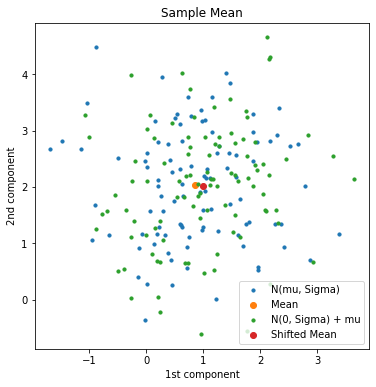

In [16]:
# 2-D samples
Xs2 = mvnorm2.rvs(size=100)
Xs3 = Xs + mu2
# Create figure
fig = plt.figure(figsize=(6,6))
# Plot original
plt.scatter(Xs2[:,0], Xs2[:, 1], label='N(mu, Sigma)', s=10, )
plt.scatter([sample_mean(Xs2)[0]], [sample_mean(Xs2)[1]], label='Mean')
# Plot shifted
plt.scatter(Xs3[:,0], Xs3[:, 1], label='N(0, Sigma) + mu', s=10)
plt.scatter([sample_mean(Xs3)[0]], [sample_mean(Xs3)[1]], label='Shifted Mean')
# Figure information
plt.xlabel('1st component'); plt.ylabel('2nd component')
plt.title('Sample Mean'); plt.legend()

### What about "covariance matrix"?

We'll need to introduce more probabilistic concepts and linear algebra to begin unpacking this term.

### Definition: Covariance

The **covariance** between two random variables $X$ and $Y$ measures the linear dependence between two random variables.

\begin{align*}
Cov(X, Y) & = \mathbb{E}( (X - \mathbb{E}(X))(Y - \mathbb{E}(Y))) \tag{definition} \\
& = \mathbb{E}( XY - Y\mathbb{E}(X) - X\mathbb{E}(Y) + (\mathbb{E}(X))(\mathbb{E}(Y)) ) \tag{distributivity} \\
& = \mathbb{E}(XY) - \mathbb{E}(Y)\mathbb{E}(X) - \mathbb{E}(X)\mathbb{E}(Y) + (\mathbb{E}(X))(\mathbb{E}(Y)) ) \tag{linearity of expectation} \\
& = \mathbb{E}(XY) - \mathbb{E}(X)\mathbb{E}(Y) \tag{simplication}
\end{align*}

The expectation is with respect to (w.r.t.) the joint distribution of $X$ and $Y$.

#### Covariance's relationship with variance

\begin{align*}
Cov(X, X) & = \mathbb{E}(XX) - \mathbb{E}(X)\mathbb{E}(X) \\
& = \mathbb{E}(X^2) - \mathbb{E}(X)^2 \\
& = Var(X)
\end{align*}

#### Definition: Covariance Matrix

Let $X = (X_1 \dots X_N)$ be a random vector. The **covariance matrix** is defined as
\begin{align*}
Cov(X) & = \mathbb{E}((X - \mathbb{E}(X))(X - \mathbb{E}(X))^T) \\
& = \begin{pmatrix}
Cov(X_1, X_1) & \dots & Cov(X_1, X_N) \\
\vdots & \ddots & \vdots \\
Cov(X_N, X_1) & \dots & Cov(X_N, X_N) \\
\end{pmatrix}
\end{align*}

#### Definition: Cross-Covariance

Let $X = (X_1 \dots X_N)$ and $Y = (Y_1 \dots Y_N)$ be two random vectors.
The **cross-covariance** is defined as
\begin{align*}
Cov(X, Y) & = \mathbb{E}((X - \mathbb{E}(X))(Y - \mathbb{E}(Y))^T) \\
& = \begin{pmatrix}
Cov(X_1, Y_1) & \dots & Cov(X_1, Y_N) \\
\vdots & \ddots & \vdots \\
Cov(X_N, Y_1) & \dots & Cov(X_N, Y_N) \\
\end{pmatrix}
\end{align*}

There's a lot more to say about the covariance matrix. First, let's get back to sampling view.

#### Definition: Sample Covariance

Suppose the matrix contains all the samples centered with the sample mean as rows.
$$
X = \begin{pmatrix}
X_1 - \bar{\mu} \\
\vdots \\
X_N - \bar{\mu}
\end{pmatrix}^{N \times D}
$$

Then the **sample covariance** is defined as
$$
\bar{\Sigma} = \frac{1}{N-1} X^T X
$$

In [17]:
def sample_covariance(X: np.ndarray) -> np.ndarray:
    return (X - X.mean(axis=0)).transpose() @ (X - X.mean(axis=0)) / (X.shape[0] - 1)

print("Actual covariance\n", sigma)
print("Sample covariance\n", sample_covariance(Xs))

Actual covariance
 [[1. 0.]
 [0. 1.]]
Sample covariance
 [[0.94735591 0.18601659]
 [0.18601659 1.14397438]]


### Hermitian and Positive Semi-Definite Matrices

A **covariance** matrix is a special kind of matrix. It has two special properties.
1. It is an example of a **Hermitian** matrix, i.e., $\Sigma^T = \Sigma$.
2. It is an example of a **positive semi-definite** matrix, i.e., $\Sigma = A^TA$ for some matrix $A$.

#### Property 1: Hermitian

We need to check that the covariance is symmetric, i.e., $Cov(X, Y) = Cov(Y, X)$.

\begin{align*}
Cov(X, Y) & = \mathbb{E}(XY) - \mathbb{E}(X)\mathbb{E}(Y) \tag{definition} \\
& = \mathbb{E}(YX) - \mathbb{E}(Y)\mathbb{E}(X) \tag{commutativity of multiplication} \\
& = Cov(Y, X) \tag{definition}
\end{align*}

#### Property 2: Positive Semi-Definite

Let's check an example first.

$$
\begin{pmatrix}
Cov(X_1, X_1) & Cov(X_1, X_2) \\
Cov(X_2, X_1) & Cov(X_2, X_2)
\end{pmatrix}
=
\begin{pmatrix}
a & 0 \\
b & c
\end{pmatrix}
\begin{pmatrix}
a & b \\
0 & c
\end{pmatrix}
$$

#### Checking Property 2 in the 2x2 case

Working out the matrix multiplication, we have

\begin{align*}
Cov(X_1, X_1) & = a^2 \\
Cov(X_1, X_2) & = ab \\
Cov(X_2, X_2) & = b^2 + c^2 \\
\end{align*}

Thus
\begin{align*}
a & = \sqrt{Cov(X_1, X_1)} \\
b & = Cov(X_1, X_2) / a \\
c & = \sqrt{Cov(X_2, X_2) - b^2} 
\end{align*}

#### Checking property 2 in the 2x2 case continued

But wait, this only makes sense if
$$
Cov(X_2, X_2) \geq b^2
$$
which occurs if and only if (iff)
$$
Cov(X_2, X_2) \geq Cov(X_1, X_2)^2/Cov(X_1, X_1)
$$
iff
$$
Cov(X_1, X_2)^2 \leq Cov(X_1, X_1) Cov(X_2, X_2)
$$
iff
$$
|Cov(X_1, X_2)|^2 \leq Var(X_1) Var(X_2)
$$
iff
$$
|\mathbb{E}((X_1 - \mu_{X_1})(X_2 - \mu_{X_2})|^2 \leq \mathbb{E}((X_1 - \mu_{X_1})^2)\mathbb{E}((X_2 - \mu_{X_2})^2)
$$
iff
$$
|\mathbb{E}(Z_1 Z_2)|^2 \leq \mathbb{E}(Z_1^2)\mathbb{E}(Z_2^2)
$$
where $Z_1 = X_1 - \mu_{X_1}$ and $Z_2 = X_2 - \mu_{X_2}$.

### Enter the Cauchy-Schwarz Inequality

The inequality 
$$
|\mathbb{E}(Z_1 Z_2)|^2 \leq \mathbb{E}(Z_1^2)\mathbb{E}(Z_2^2)
$$
is known as the **Cauchy-Schwarz Inequality**.

To unpack this, we'll need some definitions.

#### Definition: Inner product 

An inner product $\langle \cdot, \cdot \rangle: V \times V \rightarrow \mathbb{R}$ on a real-valued vector space is a function such that
1. symmetric: $\langle x, y \rangle = \langle y, x \rangle$
2. linear in first argument: $\langle ax + by, z \rangle = a\langle x, z \rangle b\langle y, z \rangle$
3. positive semi-definite: $\langle x, x \rangle > 0$ whenever $X$ is not $0$

#### Cauchy-Schwarz on Vector Spaces

For a general vector space $V$ and inner product $\langle \cdot, \cdot \rangle: V \times V \rightarrow \mathbb{R}$ (e.g., the dot product) we have that the **Cauchy-Schwarz inequality** holds:
$$
|\langle x, y \rangle|^2 \leq \langle x, x \rangle \langle y, y \rangle
$$

#### Example: Inner product on Random Variables as a Vector Space

Define $\langle X, Y \rangle = \mathbb{E}(XY)$. We need to check that it is
1. Symmetric: $\mathbb{E}(XY) = \mathbb{E}(YX)$. Yes.
2. Linear in first argument: $\mathbb{E}((aX + bY)Z) = \mathbb{E}(aXZ + bYZ) = a\mathbb{E}(XZ) + b\mathbb{E}(YZ)$. Yes.
3. Positive definite: $\mathbb{E}(X^2) > 0$ whenever $X$ is not constant $0$. Yes.

#### Summary

1. We wanted to show that the covariance matrix is positive-semi definite in the 2x2 case.
2. We did some linear algebra and ran into the Cauchy-Schwarz inequality.
3. This inequality is defined on vector spaces and gives one application of interpreting random variables as a vector space

### Definition: Correlation

Let's look at the inequality
$$
|Cov(X_1, X_2)|^2 \leq Var(X_1) Var(X_2)
$$
again. We can rewrite this as
$$
-1 \leq \frac{Cov(X_1, X_2)}{\sqrt{Var(X_1) Var(X_2)}} \leq 1 \,.
$$
The quantity in the middle called the **correlation**:
$$
\rho(X_1, X_2) = \frac{Cov(X_1, X_2)}{\sqrt{Var(X_1) Var(X_2)}} \,.
$$
Correlation is a "unitless" version of covariance, and Cauchy-Schwarz shows that it is bounded between -1 and 1.

#### Property 2: DxD case

We can generalize to the $D \times D$ case by induction on $D$.

### Cholesky Decomposition

The "strategy" we took above highlights an important matrix factorization of covariance matrices called **Cholesky Decomposition**.

Every symetric and positive semi-definite matrix $P$ can be factored into
$$
P = LL^T
$$
where $L$ is a lower-triangular matrix, i.e., all the entries in the top right triangle are $0$.

#### Application 1: Cholesky decomposition applied to sample covariance

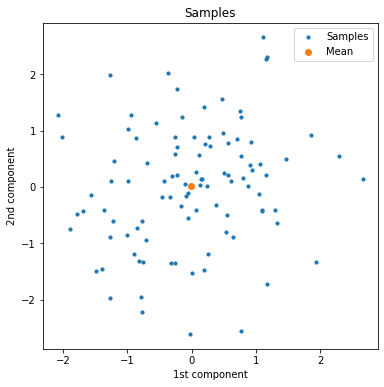

In [18]:
# Recall our draws from the multivariate Normal distribution
fig = plt.figure(figsize=(6,6))
plt.scatter(Xs[:,0], Xs[:, 1], label='Samples', s=10)
plt.scatter([sample_mean(Xs)[0]], [sample_mean(Xs)[1]], label='Mean')
plt.xlabel('1st component'); plt.ylabel('2nd component')
plt.title('Samples'); plt.legend()

In [19]:
# recall the sample covariance
A = sample_covariance(Xs)
print("Sample covariance", A)

Sample covariance [[0.94735591 0.18601659]
 [0.18601659 1.14397438]]


In [20]:
# Applying the Cholesky decomposition to the sample covariance matrix
L = np.linalg.cholesky(A)
L

array([[0.9733221 , 0.        ],
       [0.19111514, 1.05235421]])

In [21]:
L @ L.transpose(), A

(array([[0.94735591, 0.18601659],
        [0.18601659, 1.14397438]]),
 array([[0.94735591, 0.18601659],
        [0.18601659, 1.14397438]]))

#### Application 2: Cholesky decomposition applied to covariance matrix of multivariate normal

We were applying the Cholesky decomposition to the covariance matrix in the 2x2 case.
\begin{align*}
a & = \sqrt{Cov(X_1, X_1)} \\
b & = Cov(X_1, X_2) / a \\
c & = \sqrt{Cov(X_2, X_2) - b^2} 
\end{align*}

In [22]:
print("Checking 2x2 case: a")
np.sqrt(A[0, 0]), L[0, 0]

Checking 2x2 case: a


(0.9733220977493454, 0.9733220977493454)

In [23]:
print("Checking 2x2 case: b")
A[1, 0] / np.sqrt(A[0, 0]), L[1, 0]

Checking 2x2 case: b


(0.19111513871039262, 0.19111513871039262)

In [24]:
print("Checking 2x2 case: c")
np.sqrt(A[1, 1] - L[1, 0]**2), L[1, 1]

Checking 2x2 case: c


(1.052354209707843, 1.052354209707843)

#### Application 3: Sampling from a Multivariate Normal

Normal distributions have the nice property that
$$
X \sim \mathcal{N}(0, \Sigma)
$$
is equivalent to
\begin{align*}
Z & \sim \mathcal{N}(0, I) \\
Y & = LZ
\end{align*}
where $\Sigma = LL^T$.

#### Why does this work?

\begin{align*}
Cov(Y) & = L Cov(Z) L^T \tag{covariance of linear transformation} \\
 & = L I L^T \\
 & = L L^T \\
 & = \Sigma \\
 & = Cov(X)
\end{align*}

In [25]:
# Create a matrix following Cholesky decomposition
L = np.array([[sp.stats.norm().rvs(), 0.0], [sp.stats.norm().rvs(), sp.stats.norm().rvs()]])
A = L @ L.transpose()
A

array([[0.238705  , 0.17458479],
       [0.17458479, 1.08752466]])

In [26]:
L2 = np.linalg.cholesky(A)
L2

array([[0.48857445, 0.        ],
       [0.35733507, 0.97971236]])

In [27]:
# Ntoice that the factorization is not unique
L @ L.transpose(), L2 @ L2.transpose()

(array([[0.238705  , 0.17458479],
        [0.17458479, 1.08752466]]),
 array([[0.238705  , 0.17458479],
        [0.17458479, 1.08752466]]))

Sample covariance 1 [[0.29747419 0.27918798]
 [0.27918798 1.05460793]]
Sample covariance 2 [[0.23127815 0.20717324]
 [0.20717324 1.01041051]]


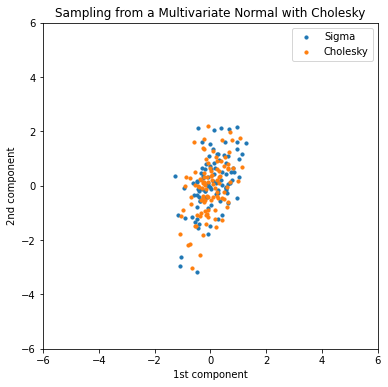

In [28]:
# Sample first normal distribution
mvnorm1 = scipy.stats.multivariate_normal(mean=np.zeros(2), cov=A)
Xs1 = mvnorm1.rvs(size=100)
print("Sample covariance 1", sample_covariance(Xs1))

# Sample second normal distribution
mvnorm2 = scipy.stats.multivariate_normal(mean=np.zeros(2), cov=np.eye(2))
Xs2 = np.array([L2 @ x for x in mvnorm2.rvs(size=100)])
print("Sample covariance 2", sample_covariance(Xs2))

# Plot the distribution
fig = plt.figure(figsize=(6,6))
plt.scatter(Xs1[:,0], Xs1[:, 1], label='Sigma', s=10)
plt.scatter(Xs2[:,0], Xs2[:, 1], label='Cholesky', s=10)
plt.xlim(-6, 6); plt.ylim(-6, 6)
plt.xlabel('1st component'); plt.ylabel('2nd component')
plt.title('Sampling from a Multivariate Normal with Cholesky')
plt.legend()

#### Summary

1. Given a centered multivariate matrix of data points
$$
X = \begin{pmatrix}
X_1 - \bar{\mu} \\
\vdots \\
X_N - \bar{\mu}
\end{pmatrix}^{N \times D}
$$
we can construct a sample covariance matrix.
2. This covariance matrix is symmetric and positive semi-definite.
3. We can thus apply Cholesky decomposition to factor this matrix.
4. Along the way, we encountered important concepts such as Cauchy-Shwarz inequality and correlation.
5. Cholesky decomposition can be used to generate samples from a multivariate normal distribution with identity covariance matrix.

### Eigenvalue Decomposition

1. The Cholesky decomposition gives one way to factorize a covariance matrix.
2. We might wonder if it's possible to further simplify the description of a covariance matrix.
3. Eigenvalue decomposition is one way to do this.

#### Definition: Eigenvalues and Eigenvectors

An **eigenvector** and **eigenvalue** of a matrix $A$ is any non-zero vector $x$ and scalar $\lambda$ such that
$$
Ax = \lambda x \,.
$$

In words, an eigenvector of a linear transformation is one where it does not change it's direction.

### Definition: Eigendecomposition

A matrix is said to have an **eigendecomposition** if it can be written as
$$
\Sigma = \begin{pmatrix}
| & \vdots & | \\
u_1 & \dots & u_n \\
| & \vdots & |
\end{pmatrix}
\begin{pmatrix}
\lambda_1 & \dots & 0 \\
0 & \dots & 0 \\
0 & 0 & \lambda_n \\
\end{pmatrix}
\begin{pmatrix}
| & \vdots & | \\
u_1 & \dots & u_n \\
| & \vdots & |
\end{pmatrix}^{-1}
$$
where each $u_i$ and $\lambda_i$ is an eigenvector and eigenvalue respectively.

#### Properties: Covariance matrix eigen decomposition

1. All $\lambda_i$ are distinct and positive.
2. All $u_i$ are orthogonal.

In [29]:
# Create a matrix following Cholesky decomposition
def random_2x2_covariance():
    L = np.array([[sp.stats.norm().rvs(), 0.0], [sp.stats.norm().rvs(), sp.stats.norm().rvs()]])
    return L @ L.transpose()
A = random_2x2_covariance()
eigvals, eigvecs = np.linalg.eig(A)
eigvals, eigvecs # all positive

(array([0.37893533, 1.56274356]),
 array([[-0.99713975,  0.07557995],
        [-0.07557995, -0.99713975]]))

In [30]:
eigvecs @ np.diag(eigvals) @ np.linalg.inv(eigvecs), A

(array([[ 0.38569763, -0.08921625],
        [-0.08921625,  1.55598125]]),
 array([[ 0.38569763, -0.08921625],
        [-0.08921625,  1.55598125]]))

In [31]:
# Orthogonal
np.dot(eigvecs[:,0], eigvecs[:,1])

8.335493373897034e-19

#### Definition: Unitary Matrix

A square matrix $U$ is called **unitary** if
$$
U^{-1} = U^T \,.
$$

#### Property: the matrix of eigenvectors is unitary

$$
\begin{pmatrix}
- & u_1^T & - \\
- & \dots & - \\
- & u_n^T & -
\end{pmatrix}
\begin{pmatrix}
| & \vdots & | \\
u_1 & \dots & u_n \\
| & \vdots & |
\end{pmatrix} = 
\begin{pmatrix}
1 & \dots & 0 \\
0 & \dots & 0 \\
0 & \dots & 1 \\
\end{pmatrix}
$$

1. Clearly $u_i^T u_i = 1$.
2. Since eigenvectors are orthogonal, $u_i^T u_j = 0$ for distinct $i$ and $j$.
3. Thus the transpose of the matrix is it's inverse.

In [32]:
np.linalg.inv(eigvecs), eigvecs.transpose()

(array([[-0.99713975, -0.07557995],
        [ 0.07557995, -0.99713975]]),
 array([[-0.99713975, -0.07557995],
        [ 0.07557995, -0.99713975]]))

In [33]:
np.dot(eigvecs[:,0], eigvecs[:,1])

8.335493373897034e-19

#### So what?

Every covariance matrix $\Sigma$ can be rewritten as
\begin{align*}
\Sigma & = U\Lambda U^T \tag{eigendecomposition} \\
 & = U\sqrt{\Lambda}\sqrt{\Lambda}U^T \tag{diagonal matrix multiplication} \\
 & = U\sqrt{\Lambda}\sqrt{\Lambda}^TU^T \tag{diagonal is own transpose}\\
 & = (U\sqrt{\Lambda})(U\sqrt{\Lambda})^T \tag{transpose}
\end{align*}

1. Note that $\sqrt{\Lambda}$ is a diagonal matrix, so it can only scale vectors.
2. Recall that $U$ is unitary.
    - In particular, $(Ux)^T(Uy) = x^TU^TUy = x^T U^{-1}Uy = x^T y$.
    - This means that unitary matrices preserves the angles between vectors.
    - In other words, a unitary matrix is a "rotation".
3. So a covariance matrix gives us a stretch (the eigenvalue part) followed by a rotation (the eigenvector part)

Text(0.5, 1.0, 'Principal Directions')

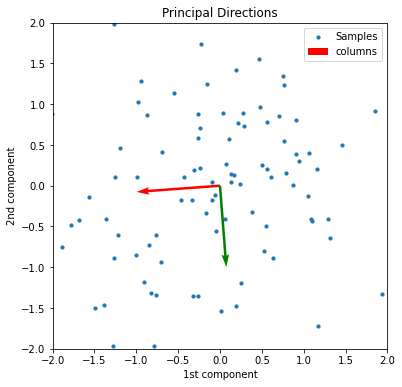

In [34]:
fig = plt.figure(figsize=(6,6))
plt.scatter(Xs[:,0], Xs[:, 1], label='Samples', s=10)
plt.xlabel('1st component'); plt.ylabel('2nd component')
origin = np.array([[0, 0],[0, 0]]) # origin point
plt.quiver(*origin, eigvecs[0,:], eigvecs[1,:], angles='xy', scale_units='xy', color=['r', 'g', 'b'], scale=1, label='columns')
plt.xlim(-2, 2); plt.ylim(-2, 2); plt.legend()
plt.title('Principal Directions')

### Multivariate Normal PDF

Now we'll finally introduce the pdf for the multivariate normal. The pdf of a multivariate normal is
$$
p_X(x) = \frac{1}{(2\pi)^{D/2}\sqrt{|\Sigma|}}\exp^{-(x - \mu)^T \Sigma^{-1} (x - \mu)/2}
$$
where $|\Sigma|$ is the **determinant** of a matrix and $D$ is the dimension of $x$ and $\mu$.

#### Aside: Determinant

1. There's a lot that can be said about determinants.
2. For our purposes, it's good enough to think about the determinant of a matrix as the "volume" of the parallelpiped created from the matrix columns as elements.
3. For example, the identity matrix
$$
\begin{pmatrix}
2 & 0 \\
0 & 3 \\
\end{pmatrix}
$$
has determinant 6 because the parallelpiped with sides $(2 \, 0)$ and $(0 \, 3)$ creates a square with volume 6.
4. The determinant of a **diagonal matrix** is thus the product of the elements on the diagonal, i.e.,
$$
\left| \begin{pmatrix}
a_1 & \dots & 0 \\
0 & \ddots & 0 \\
0 & \dots & a_D \\
\end{pmatrix} \right| = \prod_{d=1}^D a_d
$$
5. The determinant has the following nice properties
$$
|AB| = |A| |B| \,.
$$ and
$$
|A^{-1}| = |A|^{-1}
$$
This property can be used to compute determinants in practice.
6. The determinant of an invertible matrix is non-zero, i.e., $A^{-1}$ exists iff $|A| \neq 0$.

In [35]:
sp.linalg.det(np.array([[2.0, 0.0], [0.0, 3.0]]))

6.0

In [36]:
sp.linalg.det(np.array([[2.0, 2.0], [-1.0, 3.0]]))

8.0

In [37]:
sp.linalg.det(np.array([[2.0, 0.0], [0.0, 3.0]]) @ np.array([[2.0, 2.0], [-1.0, 3.0]]))

48.0

<IPython.core.display.Javascript object>


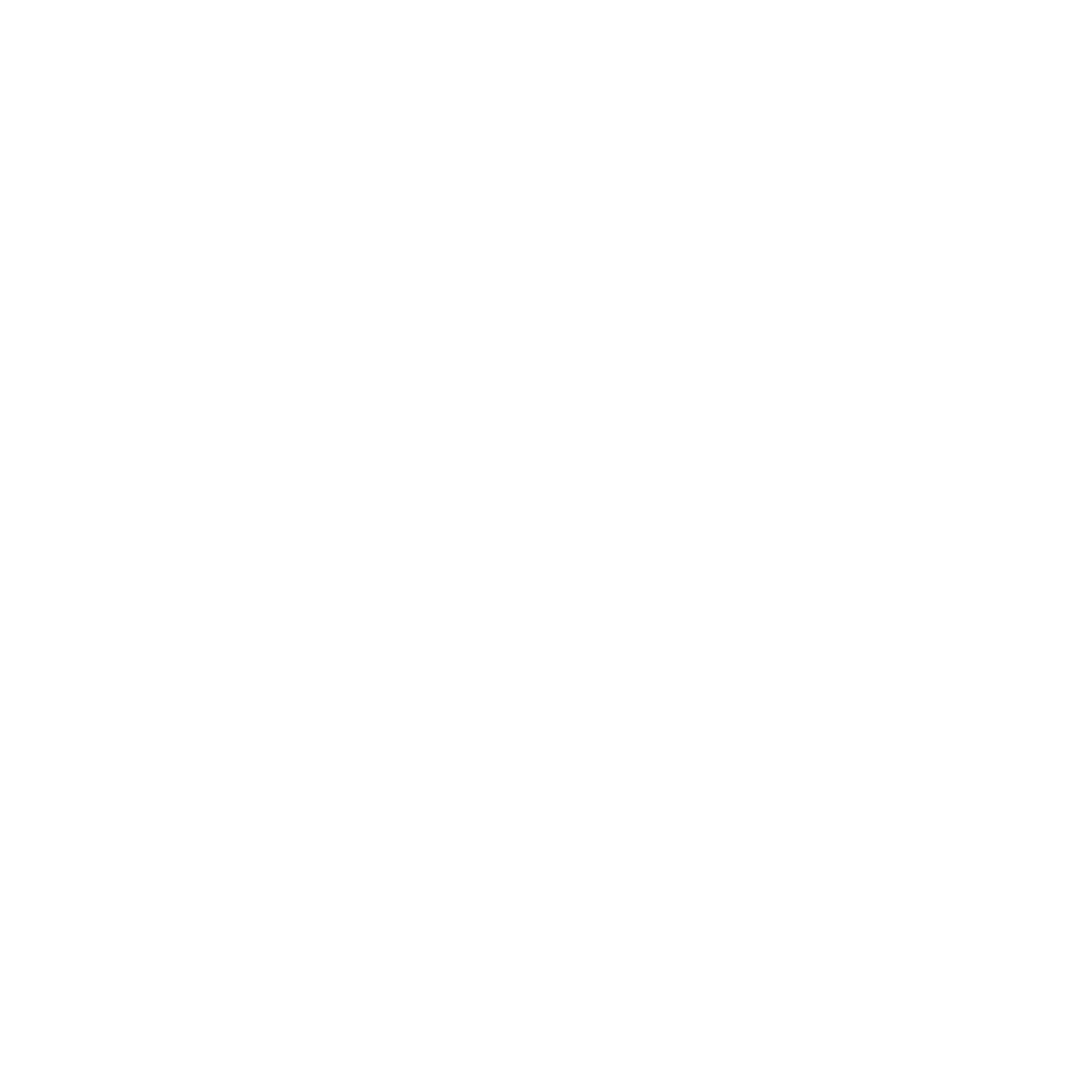

Text(0.5, 0.92, '2D Multivariate Normal PDF')

In [38]:
mu = np.zeros(2)
sigma = np.eye(2)
mvnorm = scipy.stats.multivariate_normal(mean=mu, cov=sigma)

x = np.linspace(-6., 6.); y = np.linspace(-6., 6.)
xx, yy = np.meshgrid(x, y, indexing='ij') # Grid of |x| * |y| values
zz = np.array([[mvnorm.pdf([xx[i, j], yy[i, j]]) for j in range(len(y))] for i in range(len(x))])

%matplotlib notebook
fig = plt.figure(figsize=(6,6)); ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, zz)
plt.title('2D Multivariate Normal PDF')

[[ 6.76085813 -2.4782782 ]
 [-2.4782782   1.75642864]]


<IPython.core.display.Javascript object>


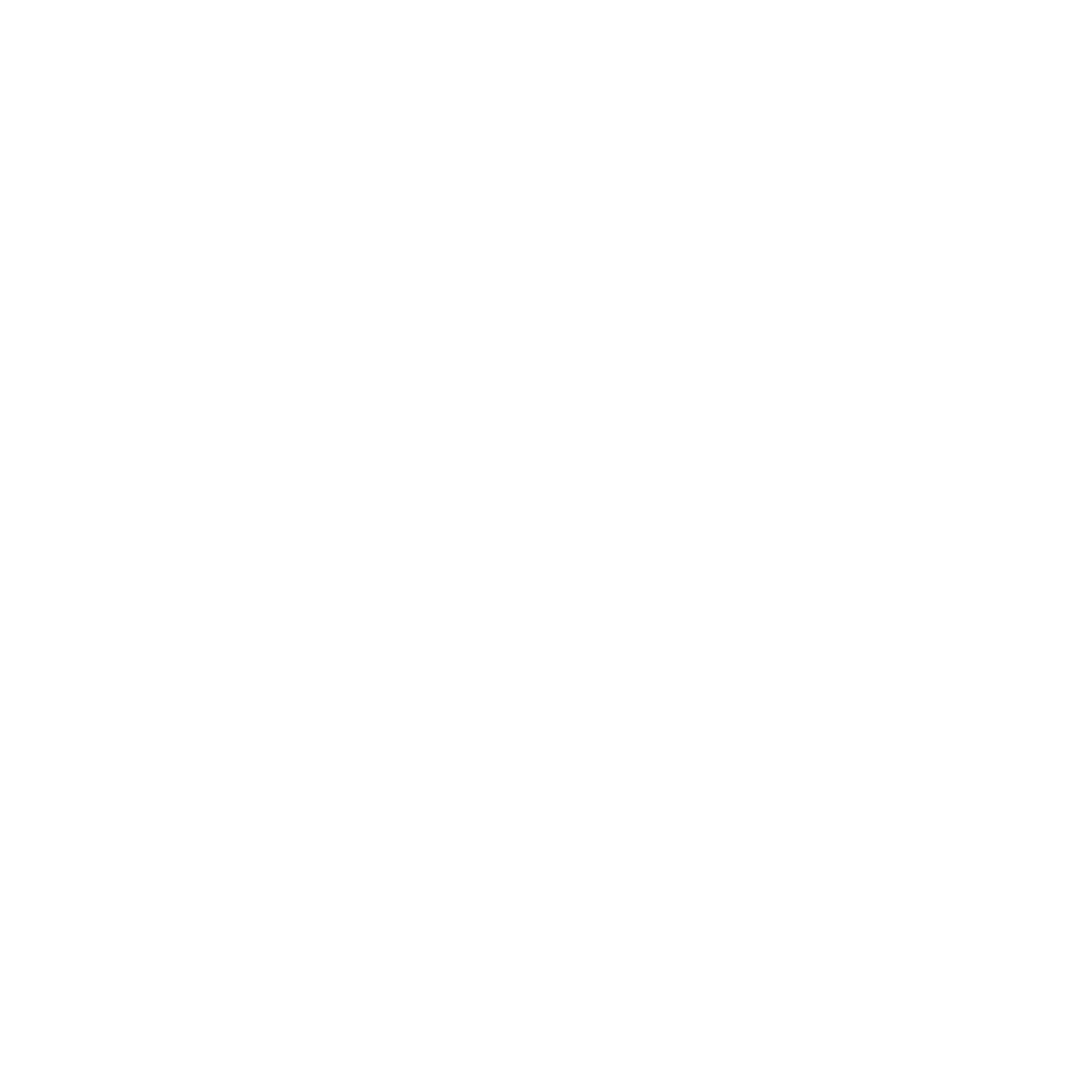

Text(0.5, 0.92, '2D Multivariate Normal PDF')

In [39]:
mu = np.array([1.0, 1.0])
sigma = random_2x2_covariance(); print(sigma)
mvnorm = sp.stats.multivariate_normal(mean=mu, cov=sigma)

x = np.linspace(-6., 6.); y = np.linspace(-6., 6.)
xx, yy = np.meshgrid(x, y, indexing='ij') # Grid of |x| * |y| values
zz = np.array([[mvnorm.pdf([xx[i, j], yy[i, j]]) for j in range(len(y))] for i in range(len(x))])

%matplotlib notebook
fig = plt.figure(figsize=(6,6)); ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, zz)
plt.title('2D Multivariate Normal PDF')

#### Aside: Contour Plot

For a 2D surface embedded in 3D space, **contour** plot illustrates the curves where the z value is constant.

Text(0.5, 1.0, 'Contour plot')

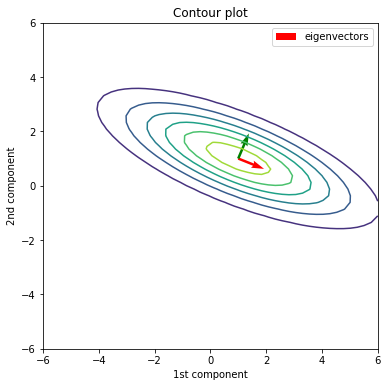

In [40]:
%matplotlib inline

fig = plt.figure(figsize=(6,6))
plt.contour(xx, yy, zz)
eigvals, eigvecs = np.linalg.eig(sigma)
origin = np.array([mu, mu]) # origin point
plt.quiver(*origin, eigvecs[0,:], eigvecs[1,:], angles='xy', scale_units='xy', color=['r', 'g', 'b'], scale=1, label='eigenvectors')
plt.xlabel('1st component'); plt.ylabel('2nd component')
plt.legend(); plt.title('Contour plot')

### Multivariate Normal: Marginal Distributions

Recall that the joint density is
$$
p_{X}(x) = \frac{1}{(2\pi)^{D/2}\sqrt{|\Sigma|}}\exp^{-(x - \mu)^T \Sigma^{-1} (x - \mu)/2}
$$
where
$$
x = (x_1, \dots, x_N, x_{N+1}, \dots, x_{N+M}) \,.
$$

We are going to break the vector $x$ into
$$
x^1 = (x_1, \dots, x_N)
$$
and
$$
x^2 = (x_{N+1}, \dots, x_{N+M})
$$
so that we have two parts. We can now choose to marginalize $x^1$ or $x^2$.

#### Notation for marginals

Let $$
\mu = \begin{pmatrix}
\mu_1 \\
\mu_2
\end{pmatrix}
$$
be the mean vector where $\mu_1$ has dimension $M$ and $\mu_2$ as dimension $N$.
Let $$
\Sigma = \begin{pmatrix}
\Sigma_{11} & \Sigma_{12} \\
\Sigma_{21} & \Sigma_{22} \\
\end{pmatrix}^{(M + N) \times (M + N)}
$$ be the covariance matrix where $\Sigma_{11}^{M \times M}$, $\Sigma_{12}^{M \times N}$, $\Sigma_{21}^{N \times M}$, and $\Sigma_{22}^{N \times N}$.
Let $$
\Lambda = \Sigma^{-1} = \begin{pmatrix}
\Lambda_{11} & \Lambda_{12} \\
\Lambda_{11} & \Lambda_{22} \\
\end{pmatrix}
$$ be the **precision** matrix.

#### Marginal distributions

Then the marginal distributions are
$$
p(x^1) = \mathcal{N}(\mu_1, \Sigma_{11})
$$
and
$$
p(x^2) = \mathcal{N}(\mu_2, \Sigma_{22}) \,.
$$

These marginals are computed by solving
\begin{align*}
p(x^1) & = \int p_X((x^1 \, x^2))dx^2
\end{align*}
and
\begin{align*}
p(x^2) & = \int p_X((x^1 \, x^2))dx^1 \,.
\end{align*}

[[0.79038209 2.31007733]
 [2.31007733 7.12901014]]


Text(0.5, 1.0, 'Samples from a Multivariate Normal')

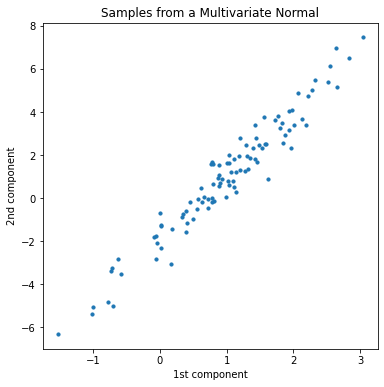

In [41]:
%matplotlib inline

mu = np.array([1.0, 1.0])
sigma = random_2x2_covariance(); print(sigma)
mvnorm = sp.stats.multivariate_normal(mean=mu, cov=sigma)
Xs = mvnorm.rvs(size=100)
fig = plt.figure(figsize=(6,6))
plt.scatter(Xs[:,0], Xs[:, 1], s=10)
plt.xlabel('1st component'); plt.ylabel('2nd component')
plt.title('Samples from a Multivariate Normal')

#### Quick spot check of marginal distributions by sampling

Text(0.5, 1.0, 'Histogram of 1st Component')

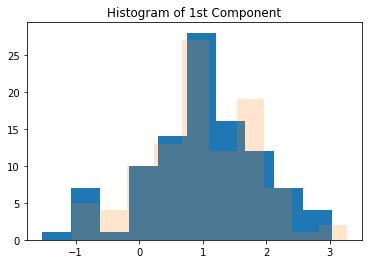

In [42]:
# Marginalizing out Y means drop the Y component for the sampling view
margy_mean = np.array([mu[0]])          # Getting mu_1
margy_cov = np.array([[sigma[0, 0]]])   # Getting Sigma_{11}
mvnorm_margy = sp.stats.multivariate_normal(mean=margy_mean, cov=margy_cov)
Xs2 = mvnorm_margy.rvs(size=100)

plt.hist(Xs[:,0], label='marginalizing joint')
plt.hist(Xs2, alpha=0.2, label='marginal directly')
plt.title('Histogram of 1st Component')

Text(0.5, 1.0, 'Histogram of 1st Component')

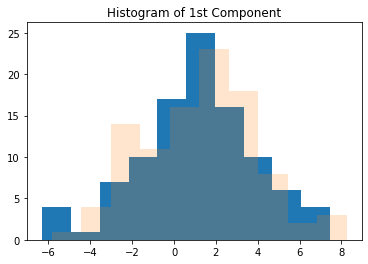

In [43]:
# Marginalizing out X means drop the X component for the sampling view
margy_mean = np.array([mu[1]])         # Getting mu_2
margy_cov = np.array([[sigma[1, 1]]])  # Getting Sigma_{22}
mvnorm_margy = sp.stats.multivariate_normal(mean=margy_mean, cov=margy_cov)
Xs2 = mvnorm_margy.rvs(size=100)

plt.hist(Xs[:,1], label='marginalizing joint')
plt.hist(Xs2, alpha=0.2, label='marginal directly')
plt.title('Histogram of 1st Component')

### Multivariate Normal: Conditional Distributions


Recall that the joint density is
$$
p_{X}(x) = \frac{1}{(2\pi)^{D/2}\sqrt{|\Sigma|}}\exp^{-(x - \mu)^T \Sigma^{-1} (x - \mu)/2}
$$
where
$$
x = (x_1, \dots, x_N, x_{N+1}, \dots, x_{N+M}) \,.
$$

We are going to break the vector $x$ into
$$
x^1 = (x_1, \dots, x_N)
$$
and
$$
x^2 = (x_{N+1}, \dots, x_{N+M})
$$
so that we have two parts. We can now choose to condition on $x^1$ or $x^2$.

#### Notation for conditional

Let $$
\mu = \begin{pmatrix}
\mu_1 \\
\mu_2
\end{pmatrix}
$$
be the mean vector where $\mu_1$ has dimension $M$ and $\mu_2$ as dimension $N$.
Let $$
\Sigma = \begin{pmatrix}
\Sigma_{11} & \Sigma_{12} \\
\Sigma_{21} & \Sigma_{22} \\
\end{pmatrix}^{(M + N) \times (M + N)}
$$ be the covariance matrix where $\Sigma_{11}^{M \times M}$, $\Sigma_{12}^{M \times N}$, $\Sigma_{21}^{N \times M}$, and $\Sigma_{22}^{N \times N}$.

### Multivariate Normal: Conditional Distributions

The conditional of $x^1$ given $x^2$ is
$$
p(x^1 | x^2) = \mathcal{N}(x^1 | \mu_{1|2}, \Sigma_{1|2})
$$
where
1.
\begin{align*}
\mu_{1|2} & = \mu_1 + \Sigma_{12}\Sigma_{22}^{-1}(y_2 - \mu_2) \\
& = \Sigma_{1|2}(\Lambda_{11}\mu_1 - \Lambda_{12}(y_2 - \mu_2))
\end{align*}
2.
$$
\Sigma_{12} = \Sigma_{11} - \Sigma_{12}\Sigma_{22}^{-1}\Sigma_{21}
$$

#### In terms of precision matrices

Recall $$
\Lambda = \Sigma^{-1} = \begin{pmatrix}
\Lambda_{11} & \Lambda_{12} \\
\Lambda_{11} & \Lambda_{22} \\
\end{pmatrix}
$$ is the precision matrix. In terms of precision matrices,
1. 
$$
\mu_{1|2} = \mu_1 - \Lambda_{11}^{-1}\Lambda_{12}(y_2 - \mu_2)
$$
2. 
$$
\Sigma_{12} = \Lambda_{11}^{-1}
$$

#### How can we derive this?

1. Schur complements
2. Inverting a Partitioned Matrix
3. Matrix inversion lemma, aka, the Sherman-Morrison-Woodbury formula.

#### Definition: Schur complements

Let 
$$
M = \begin{pmatrix}
E & F \\
G & H
\end{pmatrix}
$$
We define the **Schur complement** of $M$ with respect to invertible $H$ to be
$$
M/H = E - FH^{-1}G \,.
$$
We define the **Schur complement** of $M$ with respect to invertible $E$ to be
$$
M/E = H - GE^{-1}F \,.
$$

#### Inverting a partioned matrix

Let 
$$
M = \begin{pmatrix}
E & F \\
G & H
\end{pmatrix}
$$
be a matrix where $E$ and $H$ are invertible. Then
$$
M^{-1} = \begin{pmatrix}
(M/H)^{-1} & - (M/H)^{-1}FH^{-1} \\
-H^{-1}G(M/H)^{-1} & H^{-1} + H^{-1}G(M/H)^{-1}FH^{-1}
\end{pmatrix}
$$
if $(M/H)^{-1}$ is invertible.

#### Proof

We want to rearrange the matrices so that we can easy inversions as below
$$
\begin{pmatrix}
I & -FH^{-1} \\
0 & I 
\end{pmatrix}
\begin{pmatrix}
E & F \\
G & H 
\end{pmatrix}
\begin{pmatrix}
I & 0 \\
-H^{-1}G & I
\end{pmatrix}
=
\begin{pmatrix}
E - FH^{-1}G & 0 \\
0 & H
\end{pmatrix}
$$
where we use the assumption that $H$ is invertible.

Inverting both sides gives
$$
\begin{pmatrix}
I & 0 \\
-H^{-1}G & I
\end{pmatrix}^{-1}
\begin{pmatrix}
E & F \\
G & H 
\end{pmatrix}^{-1}
\begin{pmatrix}
I & -FH^{-1} \\
0 & I 
\end{pmatrix}^{-1}
=
\begin{pmatrix}
M/H & 0 \\
0 & H
\end{pmatrix}^{-1}
$$
where we have also used the definition of Schur's complement.

Thus
\begin{align*}
\begin{pmatrix}
E & F \\
G & H 
\end{pmatrix}^{-1}
& =
\begin{pmatrix}
I & 0 \\
-H^{-1}G & I
\end{pmatrix}
\begin{pmatrix}
M/H & 0 \\
0 & H
\end{pmatrix}^{-1}
\begin{pmatrix}
I & -FH^{-1} \\
0 & I 
\end{pmatrix} \\
& =
\begin{pmatrix}
I & 0 \\
-H^{-1}G & I
\end{pmatrix}
\begin{pmatrix}
(M/H)^{-1} & 0 \\
0 & H^{-1}
\end{pmatrix}
\begin{pmatrix}
I & -FH^{-1} \\
0 & I 
\end{pmatrix} \\
& = \begin{pmatrix}
(M/H)^{-1} & - (M/H)^{-1}FH^{-1} \\
-H^{-1}G(M/H)^{-1} & H^{-1} + H^{-1}G(M/H)^{-1}FH^{-1}
\end{pmatrix}
\end{align*}
under the assumption that $(M/H)$ is invertible.

#### This idea is symmetric

$$
\begin{pmatrix}
E & F \\
G & H 
\end{pmatrix}^{-1} = 
\begin{pmatrix}
E^{-1} + E^{-1}F(M/E)^{-1}GE^{-1} & -E^{-1}F(M/E)^{-1} \\
-(M/E)^{-1}GE^{-1} & (M/E)^{-1}
\end{pmatrix}
$$

#### Matrix Inversion Lemma 

The Sherman-Morrison-Woodbury formula
$$
(M/H)^{-1} = E^{-1} + E^{-1}F(M/E)^{-1}GE^{-1}
$$
is obtained by matching the corresponding entries of inverting a partioned matrix.

#### Derivation of Conditional of Multivariate Normal

Recall that the joint density is
$$
p_{X}(x^1, x^2) \propto exp\left(
-\frac{1}{2}
\begin{pmatrix}
x^1 - \mu_1 \\
x^2 - \mu_2 \\
\end{pmatrix}^T
\begin{pmatrix}
\Sigma_{11} & \Sigma_{12} \\
\Sigma_{21} & \Sigma_{22}
\end{pmatrix}^{-1}
\begin{pmatrix}
x^1 - \mu_1 \\
x^2 - \mu_2 \\
\end{pmatrix}\right)
$$
where $\propto$ means proportional to.

#### Goal

We will factor $p(x^1, x^2) = p(x^1|x^2) p(x^2)$.

#### Derivation

\begin{align*}
p(x^1, x^2) & \propto exp\left(
-\frac{1}{2}
\begin{pmatrix}
x^1 - \mu_1 \\
x^2 - \mu_2 \\
\end{pmatrix}^T
\begin{pmatrix}
I & 0 \\
-\Sigma_{22}^{-1}\Sigma_{21} & I
\end{pmatrix}
\begin{pmatrix}
(\Sigma/\Sigma_{22})^{-1} & 0 \\
0 & \Sigma_{22}^{-1}
\end{pmatrix}
\begin{pmatrix}
I & -\Sigma_{12}\Sigma_{22}^{-1} \\
0 & I
\end{pmatrix}^{-1}
\begin{pmatrix}
x^1 - \mu_1 \\
x^2 - \mu_2 \\
\end{pmatrix}\right) \\
& = exp\left(
-\frac{1}{2}
(x_1 - \mu_1 - \Sigma_{12}\Sigma_{22}^{-1}(x_2 -\mu_2)^T(\Sigma/\Sigma_{22})^{-1}(x_1 - \mu_1 - \Sigma_{12}\Sigma_{22}^{-1}(x_2 -\mu_2))
\right) \\
& \phantom{=} \cdot exp\left(-\frac{1}{2}(x_2 - \mu_2)^T\Sigma_{22}^{-1}(x_2 - \mu_2)\right) \\
& = p(x^1|x^2) p(x^2)
\end{align*}

### Multivariate Normal Distribution Summary

1. A **multivariate normal** distribution is notated $\mathcal{N}(\mu, \Sigma)$, and is parameterized by a $D$-dimensional mean vector $\mu$ and a $D \times D$ **covariance matrix** $\Sigma$.
$$
X \sim \mathcal{N}(\mu, \Sigma)
$$
2. A multivariate normal enables us to model $D$-dimensional data.
3. We we were introduced the covariance matrix, which enabled us to model correlations between data.
4. Along the way we saw a bunch of connections of the covariance matrix with linear algebra: unitary matrices, positive semi-definite matrices, determinants, Schur's complement, the matrix inversion lemma.
5. Finally, we saw the connection back to probability with concepts such as the marginal distributions and conditional distributions of multivariate normals.

## Back to Linear Regression

We will apply everything we've learned about multivariate normal distributions back to linear regression.

### Recalling our 3 point dataset

Suppose we want to fit a model through a dataset of three points.

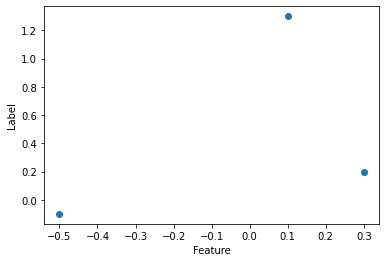

In [44]:
x1 = [0.3]; x2 = [-0.5]; x3 = [.1]                
X = np.array([x1, x2, x3])   # each row is one point
Y = [0.2, -.1, 1.3]
plt.xlabel('Feature'); plt.ylabel('Label')
plt.plot(X[:,0], Y, marker='o', linestyle='none')

### Recall the Probabilistic Model

Given dataset $(y^i, x^i)$ and parameters $\theta$, we have
\begin{align*}
p(y^i | x^i; \theta) & = \frac{1}{\sqrt{2\pi\sigma^2}}e^{(y^i - (\sum_{d=1}^D \theta_d x_d^i + \theta_{d+1}))^2/(2\sigma^2)} \\
p(y | x; \theta) & = \prod_{i=1}^N p(y^i | x^i; \theta)
\end{align*}

### Modeling with a Multivariate Normal Distribution

$$
p(y | x; \theta) = \frac{1}{(2\pi)^{N/2}\sqrt{|\Sigma|}}\exp^{-(y - \mu)^T \Sigma^{-1} (x - \mu)/2}
$$
where
$$
\mu = \begin{pmatrix}
\sum_{d=1}^D \theta_d x^1_d + \theta_{d+1} \\
\vdots \\
\sum_{d=1}^D \theta_d x^N_d + \theta_{d+1}
\end{pmatrix}
$$
and
$$
\Sigma = \begin{pmatrix}
\sigma^2 & \dots & 0 \\
0 & \ddots & 0 \\
0 & \dots & \sigma^2 \\
\end{pmatrix} = \sigma^2I
$$

#### Observation 1: Marginals are identical

Note that each 
$$
p(y^i | x^i; \theta) = \mathcal{N}(\sum_{d=1}^D \theta_d x^i_d + \theta_{d+1}, \sigma^2)
$$
by the marginal property of multivariate normal distributions.

#### Observation 2: The Probability Density is Identical

$$
\begin{align*}
p(y | x; \theta) & = \frac{1}{(2\pi)^{N/2}\sqrt{|\Sigma|}} \exp^{-(y - \mu)^T \Sigma^{-1} (y - \mu)/2}\\
& = \frac{1}{\sqrt{2\pi^N\sigma^{2N}}} \exp^{-(y - \mu)^T(y - \mu)/(2\sigma^2)} \\
& = \prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma^2}}\exp^{-(y^i - \mu_i)^2/(2\sigma^2)} \\
& = \prod_{i=1}^N p(y^i | x^i; \theta)
\end{align*}
$$
where
$$
p(y^i | x^i; \theta) = \mathcal{N}(\sum_{d=1}^D \theta_d x^i_d + \theta_{d+1}, \sigma^2)
$$

#### Observation 3: Independent and identically distributed datapoints encoded with identity covariance

$$
\Sigma = \begin{pmatrix}
\sigma^2 & \dots & 0 \\
0 & \ddots & 0 \\
0 & \dots & \sigma^2 \\
\end{pmatrix} = \sigma^2I
$$

#### Aside: Covariance and Independence

In [45]:
def cross_covariance(X: np.ndarray, Y: np.ndarray) -> np.ndarray:
    return (X - X.mean(axis=0)).transpose() @ (Y - Y.mean(axis=0)) / (Y.shape[0] - 1)

#### Independence implies 0 covariance

Variance 1st component 1.1628104906799168
Variance 2n component 0.9250601527574263
Cross Covariance between 1st and 2nd component 0.05762173656732321 0.05762173656732321


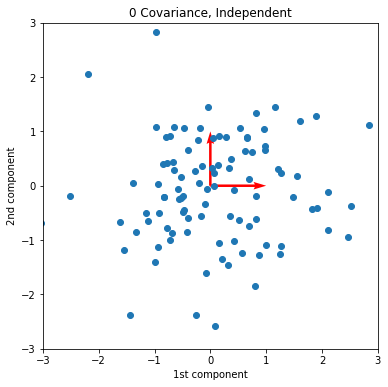

In [46]:
mu = np.array([0.0, 0.0])
sigma = np.eye(2)
mvnorm = sp.stats.multivariate_normal(mean=mu, cov=sigma)
eigvals, eigvecs = np.linalg.eig(sigma)

fig = plt.figure(figsize=(6,6))
plt.quiver(*np.array([mu, mu]), eigvecs[0,:], eigvecs[1,:], angles='xy', scale_units='xy', color=['r'], scale=1, label='eigenvectors')
Xs = mvnorm.rvs(size=100)
plt.scatter(Xs[:,0], Xs[:,1])
plt.xlim(-3, 3); plt.ylim(-3, 3)
plt.xlabel('1st component'); plt.ylabel('2nd component'); plt.title('0 Covariance, Independent')
Cov = cross_covariance(Xs, Xs)
print("Variance 1st component", Cov[0, 0])
print("Variance 2n component", Cov[1, 1])
print("Cross Covariance between 1st and 2nd component", Cov[0, 1], Cov[1, 0])

#### 0 covariance does not imply independence

Variance 1st component 1.1628104906799168
Variance 2nd component 0.9250601527574263
Cross Covariance between 1st and 2nd component 0.05762173656732321 0.05762173656732321


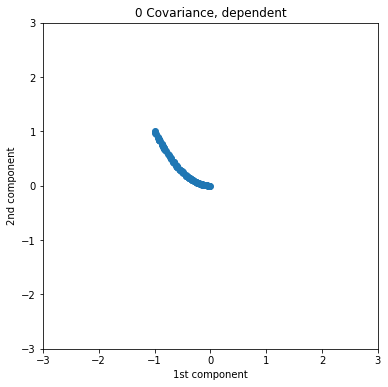

In [47]:
X1s = sp.stats.uniform(-1, 1).rvs(size=100)
X2s = X1s**2

fig = plt.figure(figsize=(6,6))
plt.scatter(X1s, X2s)
plt.xlim(-3, 3); plt.ylim(-3, 3)
plt.xlabel('1st component'); plt.ylabel('2nd component'); plt.title('0 Covariance, dependent')
Cov = cross_covariance(Xs, Xs)
print("Variance 1st component", Cov[0, 0])
print("Variance 2nd component", Cov[1, 1])
print("Cross Covariance between 1st and 2nd component", Cov[0, 1], Cov[1, 0])

#### Positive covariance

Variance 1st component 0.7182726930392782
Variance 2nd component 0.7385081906945763
Cross Covariance between 1st and 2nd component 0.5508045283616927 0.5508045283616927


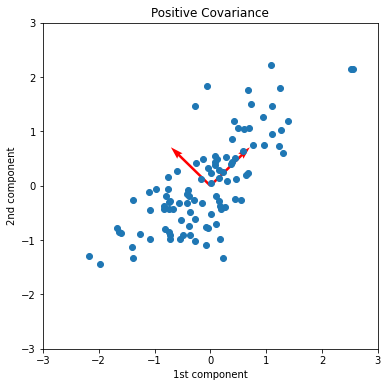

In [48]:
mu = np.array([0.0, 0.0])
sigma = np.array([[.707, -.707], [.707, .707]]) @ np.diag([1.0, .2]) @ np.array([[.707, -.707], [.707, .707]]).transpose()
mvnorm = sp.stats.multivariate_normal(mean=mu, cov=sigma)
eigvals, eigvecs = np.linalg.eig(sigma)

fig = plt.figure(figsize=(6,6))
plt.quiver(*np.array([mu, mu]), eigvecs[0,:], eigvecs[1,:], angles='xy', scale_units='xy', color=['r'], scale=1, label='eigenvectors')
Xs = mvnorm.rvs(size=100)
plt.scatter(Xs[:,0], Xs[:,1])
plt.xlim(-3, 3); plt.ylim(-3, 3)
plt.xlabel('1st component'); plt.ylabel('2nd component'); plt.title('Positive Covariance')
Cov = cross_covariance(Xs, Xs)
print("Variance 1st component", Cov[0, 0])
print("Variance 2nd component", Cov[1, 1])
print("Cross Covariance between 1st and 2nd component", Cov[0, 1], Cov[1, 0])

#### Negative covariance

Variance 1st component 0.6922698759029854
Variance 2nd component 0.5976412486882785
Cross Covariance between 1st and 2nd component -0.39882672640906525 -0.39882672640906525


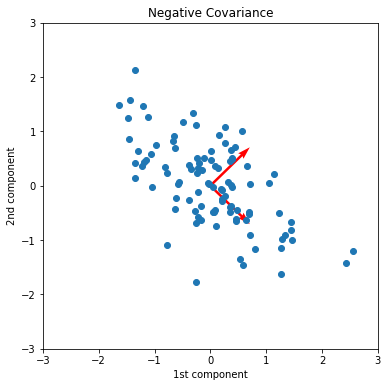

In [49]:
mu = np.array([0.0, 0.0])
sigma = np.array([[.707, -.707], [.707, .707]]) @ np.diag([.2, 1.0]) @ np.array([[.707, -.707], [.707, .707]]).transpose()
mvnorm = sp.stats.multivariate_normal(mean=mu, cov=sigma)
eigvals, eigvecs = np.linalg.eig(sigma)

fig = plt.figure(figsize=(6,6))
plt.quiver(*np.array([mu, mu]), eigvecs[0,:], eigvecs[1,:], angles='xy', scale_units='xy', color=['r'], scale=1, label='eigenvectors')
Xs = mvnorm.rvs(size=100)
plt.scatter(Xs[:,0], Xs[:,1])
plt.xlim(-3, 3); plt.ylim(-3, 3)
plt.xlabel('1st component'); plt.ylabel('2nd component'); plt.title('Negative Covariance')
Cov = cross_covariance(Xs, Xs)
print("Variance 1st component", Cov[0, 0])
print("Variance 2nd component", Cov[1, 1])
print("Cross Covariance between 1st and 2nd component", Cov[0, 1], Cov[1, 0])

## Summary

1. We saw that random variables formed a vector space.
    - This is our first example of a vector space that we couldn't visualize as a base point + direction.
    - We defined expectation which we saw was linear.
    - This enabled us to define the notion of covariance.
2. We then looked at multivariate normal distributions.
    - A multivariate normal distribution defines a distribution on vectors. It produces a random vector.
    - A random vector is a vector in the space of random variables!
    - We saw that the notion of covariance matrix tied together many ideas in linear algebra and probability.
3. Finally we saw that a multivariate normal distribution could be used to explain a linear regression.

## Gaussian Process Regression

1. We've built up a lot of powerful machinery.
2. We can now use this machinery to begin creating non-linear models.
3. The first one we will look at is called a Gaussian Process (GP) regression.

### Problem

A linear model can only fit the data if the underlying model is generated by a line.

Text(0.5, 1.0, 'Example Data')

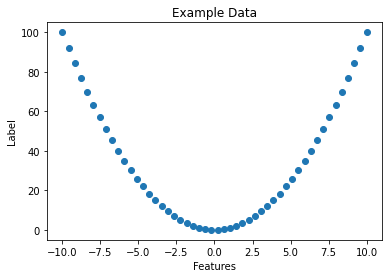

In [50]:
def nonlinear_f(x):
    return x**2

xs = np.linspace(-10, 10)
ys = np.array([nonlinear_f(x) for x in xs])
plt.plot(xs, ys, marker='o', linestyle='None', label='data')
plt.xlabel('Features'); plt.ylabel('Label'); plt.title('Example Data')

In [51]:
# Our simple linear model again
def linear_algebra_solve(X, Y):
    X_p = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
    return np.linalg.solve(X_p.transpose() @ X_p, X_p.transpose() @ Y)

def linear_predict(weights, x):
    return np.dot(weights[:-1], x) + weights[-1]

Text(0.5, 1.0, 'Failure of Linear Model')

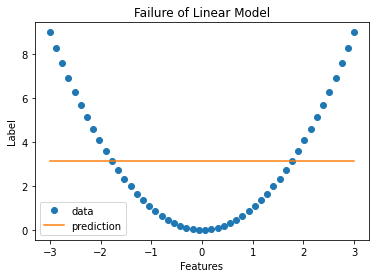

In [52]:
xs = np.linspace(-3, 3)
ys = np.array([nonlinear_f(x) for x in xs])
weights = linear_algebra_solve(xs.reshape(-1, 1), ys)
ys_pred = np.array([linear_predict(weights, np.array([x])) for x in xs])
plt.plot(xs, ys, marker='o', linestyle='None', label='data')
plt.plot(xs, ys_pred, label='prediction')
plt.xlabel('Features'); plt.ylabel('Label')
plt.legend(); plt.title('Failure of Linear Model')

### Many Possible Solutions

1. Make our model more powerful by making it non-linear.
2. Use a linear model in a higher dimensional space. This is called the **kernel trick**.

### Solution 1: Kernel Trick with Linear Regression

1. Choose a set $\phi_i$ of **feature mappings** that map the original input into a higher dimensional output space.
2. Perform a linear regression in the higher dimensional output space.
3. The idea is that the function may be linear in the higher dimensional output space.

Use
$$
\begin{pmatrix}
| & \dots & | \\
\phi_1(X) & \dots & \phi_M(X) \\
| & \dots & |
\end{pmatrix}
$$
instead of original data matrix $X$.

Solve
$$
\begin{pmatrix}
| & \dots & | & 1 \\
\phi_1(X) & \dots & \phi_M(X) & 1 \\
| & \dots & | & 1
\end{pmatrix} \theta = Y
$$
for weights $\theta$.

In [53]:
def feature_1(x):
    return x

def feature_2(x):
    return x**2

In [54]:
xs1 = np.array([feature_1(x) for x in np.linspace(-10, 10)])
xs2 = np.array([feature_2(x) for x in np.linspace(-10, 10)])
ys = np.array([nonlinear_f(x) for x in xs])

Text(0.5, 0.92, 'Kernel Trick')

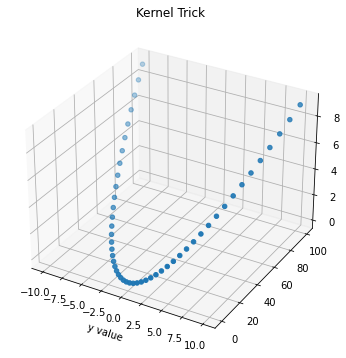

In [55]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs1, xs2, ys)
plt.xlabel('basis1'); plt.xlabel('basis2'); plt.xlabel('y value')
plt.title('Kernel Trick')

Weights [-1.01865145e-31  1.00000000e+00 -5.62469594e-15]


Text(0.5, 0.92, 'Kernel Trick with Fitted Linear Regression')

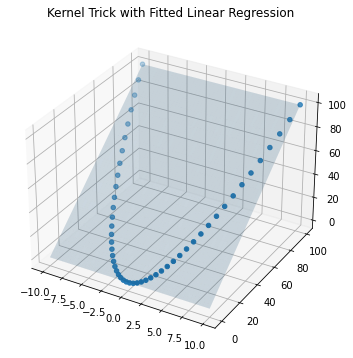

In [56]:
X = np.stack([xs1, xs2], axis=1)
Y = np.array([nonlinear_f(x) for x in xs1])
weights = linear_algebra_solve(X, Y)
print("Weights", weights)

xx, yy = np.meshgrid(xs1, xs2, indexing='ij')
zz = np.array([[linear_predict(weights, np.array([x1, x2])) for x2 in xs2] for x1 in xs1])

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs1, xs2, Y, 'Data')
ax.plot_surface(xx, yy, zz, alpha=0.1, label='Linear Regression')
plt.title('Kernel Trick with Fitted Linear Regression')

### Probabilistic View of Kernel Trick

1. Let's interpret the kernel trick with linear regression in terms of the probabilistic view again.
2. We get that the standard linear regression solution is the maximum of
$$
p(y| x; \theta) = \mathcal{N}(\sum_{i=1}^M\theta_i\phi_i(x) + \theta_{i+1}, \sigma^2I) \,.
$$
3. Notice that the mean of the multivariate normal is where the non-linearity in terms of our function parameters shows up.

### Solution 2: More Powerful Model

1. Is there another way to create a nonlinear model with a multivariate normal?
2. Let's start with the model
$$
p\left(\begin{pmatrix}
y \\
y^*
\end{pmatrix}
| 
\begin{pmatrix}
x \\
x^*
\end{pmatrix}
\right) = \mathcal{N}(\mu, \Sigma)
$$
where $x = (x^i, y^i)_{1 \leq i \leq N}$ are data,
$\mu \in \mathbb{R}^D$ is a mean, $\phi: \mathbb{R}^D \rightarrow \mathbb{R}^M$ is a feature map,
$$
\Sigma = \begin{pmatrix}
- & \phi(x^1) & - \\
- & \vdots & - \\
- & \phi(x^N) & - \\
- & \phi(x^*) & -
\end{pmatrix}
\begin{pmatrix}
| & \dots & | & |\\
\phi(x^1) & \dots & \phi(x^N) & \phi(x^*) \\
| & \dots & | & | \\
\end{pmatrix} \,.
$$

1. The matrix is clearly a covariance matrix as $A^TA$ is always positive semi-definite.
2. Notice that we no longer have any parameters $\theta$. Such a method is called a **kernel method** (not to be confused with kernel trick) because it uses all the data points in the training dataset.
3. Notice that we are also modeling the distribution of $y^*$ given $x^*$ which did not happen in our previous models. We do this because instead of learning parameters $\theta$ and using it to construct a prediction $y^*$ given an $x^*$, we are going to construct a distribution by conditioning.

#### Conditioning

Construct a model by conditioning on the dataset $(x^i, y^i)_{1 \leq i \leq N}$.
Suppose
$$
\Sigma = \begin{pmatrix}
\Sigma_{X, X} & \Sigma_{*, X} \\
\Sigma_{X, *}&* \Sigma_{*, *}
\end{pmatrix}
$$
where
$$
\Sigma_{X, *} = \begin{pmatrix}
- & \phi(x^*) & -
\end{pmatrix}
\begin{pmatrix}
| & \dots & | \\
\phi(x^1) & \dots & \phi(x^N) \\
| & \dots & | & \\
\end{pmatrix} = \Sigma_{*, X}^T \,,
$$
$$
\Sigma_{X, X } = \begin{pmatrix}
- & \phi(x^1) & - \\
- & \vdots & - \\
- & \phi(x^N) & - \\
\end{pmatrix}
\begin{pmatrix}
| & \dots & | \\
\phi(x^1) & \dots & \phi(x^N) \\
| & \dots & | \\
\end{pmatrix} \,,
$$
and
$$
\Sigma_{*, *} = \begin{pmatrix}
- & \phi(x^*) & -
\end{pmatrix}
\begin{pmatrix}
| \\
\phi(x^*) \\
| \\
\end{pmatrix} \,.
$$.

Then
$$
p\left(\begin{pmatrix}
y^*
\end{pmatrix}
| 
\begin{pmatrix}
X \\
x^*
\end{pmatrix}, y
\right) = \mathcal{N}(\Sigma^{T}_{X, *}\Sigma^{-1}_{X, X}(y - \mu(X)) + \mu(x^*), \Sigma_{*, *} - \Sigma_{X,*}\Sigma^{-1}_{X, X}\Sigma_{X, *})
$$
which follows from the conditional of a multivariate normal.

#### Conditioning creates nonlinearity

The **posterior predictive mean**
$$
\int y^* p\left(\begin{pmatrix}
y^*
\end{pmatrix}
| 
\begin{pmatrix}
X \\
x^*
\end{pmatrix}, y
\right) dy^* = \Sigma^{T}_{X, *}\Sigma^{-1}_{X, X}(y - \mu(X))
$$
is nonlinear because $\Sigma^{T}_{X, *}$ is a nonlinear combination of $y^*$.

### Definition: Gaussian Process

We have just constructed what is known as a **Gaussian Process** (GP). A GP is a model parameterized by
1. a **mean function** $\mu: \mathbb{R}^D \rightarrow \mathbb{R}$ and
2. a positive definite **kernel function** $k: \mathbb{R}^D \times \mathbb{R}^D \rightarrow \mathbb{R}$ such that $k(x, y) = \langle \phi(x), \phi(y) \rangle$ for some feature map $\phi: \mathbb{R}^D \rightarrow \mathbb{H}$ where $\mathbb{H}$ is a **Hilbert space** that allows for infinite dimensional features. Under this parameterization, $k$ is a function that measures the similarity between the two inputs $x$ and $y$. $k(x, y) = 0$ means completely dissimilar and $k(x, y) = 1$ means identical.

The **posterior predictive distribution** is given as
$$
p\left(\begin{pmatrix}
y^*
\end{pmatrix}
| 
\begin{pmatrix}
X \\
x^*
\end{pmatrix}, y
\right) = \mathcal{N}(\Sigma^{T}_{X, *}\Sigma^{-1}_{X, X}(y - \mu(X)), \Sigma_{*, *} - \Sigma_{X,*}\Sigma^{-1}_{X, X}\Sigma_{X, *}) \,.
$$

The quantity 
$$
\alpha = \Sigma^{-1}_{X, X}(y - \mu(X))
$$
are called the **weights** of the GP regression.

Observe that
$$
\Sigma = \begin{pmatrix}
- & \phi(x^1) & - \\
- & \vdots & - \\
- & \phi(x^N) & - \\
- & \phi(x^*) & -
\end{pmatrix}
\begin{pmatrix}
| & \dots & | & |\\
\phi(x^1) & \dots & \phi(x^N) & \phi(x^*) \\
| & \dots & | & | \\
\end{pmatrix} = \begin{pmatrix}
k(x^1, x^1) & \dots & k(x^1, x^N) & k(x^1, x^*)\\
\vdots & \dots & \vdots & \vdots \\
k(x^N, x^1) & \dots & k(x^N, x^N) & k(x^N, x^*) \\
k(x^*, x^1) & \dots & k(x^*, x^N) & k(x^*, x^*) \\
\end{pmatrix}
$$

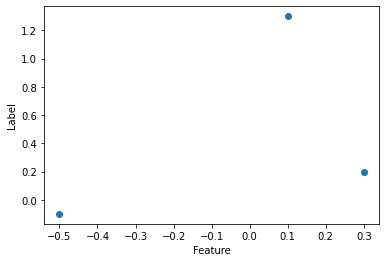

In [57]:
x1 = [0.3]; x2 = [-0.5]; x3 = [.1]                
X = np.array([x1, x2, x3])   # each row is one point
Y = [0.2, -.1, 1.3]
plt.xlabel('Feature'); plt.ylabel('Label')
plt.plot(X[:,0], Y, marker='o', linestyle='none')

In [58]:
# GP Mean
def mean(x: np.ndarray) -> np.ndarray:
    return np.zeros(x.shape[0])

# GP Kernel (radial basis function)
def kernel(lengthscale: float, x: np.ndarray, y: np.ndarray) -> float:
    return np.exp(-(x - y)**2/(2. * lengthscale))

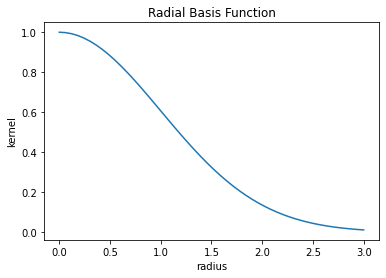

In [59]:
rs = np.linspace(0.0, 3.0)
plt.xlabel('radius'); plt.ylabel('kernel'); plt.title('Radial Basis Function')
plt.plot(rs, [kernel(1.0, np.array([0.0]), np.array([r])) for r in rs])

In [60]:
def solve_posterior_predictive_mean(lengthscale: float,
                                    mean: Callable[[np.ndarray], np.ndarray],
                                    kernel: Callable[[float, np.ndarray, np.ndarray], np.ndarray],
                                    X: np.ndarray,
                                    Y: np.ndarray) -> np.ndarray:
    K = np.stack([np.array([kernel(lengthscale, x1, x2) for x2 in X]).reshape(-1) for x1 in X])
    # Adding noise to the covariance matrix
    K = K + 1e-7*np.eye(K.shape[0])
    b = Y - mean(X)
    # NOTE: this is a naive implementation , typically we can use the special properties of
    # the covariance matrix    
    return np.linalg.solve(K, b)

def predict_posterior_predictive_mean(lengthscale: float,
                                      mean: Callable[[np.ndarray], np.ndarray],
                                      kernel: Callable[[float, np.ndarray, np.ndarray], np.ndarray],
                                      X: np.ndarray,
                                      alpha: np.ndarray,
                                      xstar: np.ndarray) -> np.ndarray:
    return np.dot(np.array([kernel(lengthscale, x, xstar) for x in X]).reshape(-1), alpha) + mean(xstar)

#### Aside: Solving linear equations involving covariance matrices

We want to solve
$$
Kx = b
$$
for $x$ given $K$ and $b$.

Observe that
$$
LL^Tx = b
$$
where $K = LL^T$ by Cholesky.

Thus we can
1. Perform Cholesky decomposition to obtain $K = LL^T$.
2. Solve $Ly = b$ for y.
3. Now we observe that $L^Tx = y$ and so we solve this for $x$.

In [61]:
def covariance_solve(K, b):
    L = np.linalg.cholesky(K)
    y = sp.linalg.solve_triangular(L, b, lower=True)
    return sp.linalg.solve_triangular(L.transpose(), y)

K = random_2x2_covariance()
b = np.array([1.0, 0.0])
covariance_solve(K, b), np.linalg.solve(K, b)

(array([413.61129869, -41.40736335]), array([413.61129869, -41.40736335]))

#### Observation 1: Perfect Interpolation

A GP exactly interpolates the points in the dataset.

Weights [-132.3678069   -44.45788619  168.1810799 ]


Text(0, 0.5, 'Label')

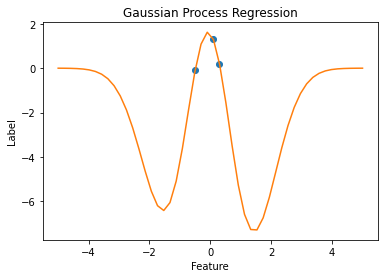

In [70]:
lengthscale = 1.
alpha = solve_posterior_predictive_mean(lengthscale, mean, kernel, X, Y)
print("Weights", alpha)
plt.plot(X[:,0], Y, marker='o', linestyle='none')
pred = partial(predict_posterior_predictive_mean, lengthscale, mean, kernel, X, alpha)
xs = np.linspace(-5, 5)
y_preds = [pred(np.array([x])) for x in xs]
plt.plot(xs, y_preds); plt.title('Gaussian Process Regression')
plt.xlabel('Feature'); plt.ylabel('Label')

#### Observation 2: Effect of Mean

1. A GP reverts to the mean on a point far away from points in the dataset.
2. Recall
\begin{align*}
f(x^*) & = \Sigma^{T}_{X, *}\Sigma^{-1}_{X, X}(y - \mu(X)) + \mu(x^*) \\
 & = \sum_{i=1}^N \alpha_i k(x_i, x^*) + \mu(x^*)
\end{align*}
where $\alpha = \Sigma^{-1}_{X, X}(y - \mu(X))$.
3. Thus $f(x^*) \approx \mu(x^*)$ when $k(x_i, x^*) \approx 0$ for every $i$.

Weights [-132.3678069   -44.45788619  168.1810799 ]


Text(0.5, 1.0, 'Gaussian Process Regression')

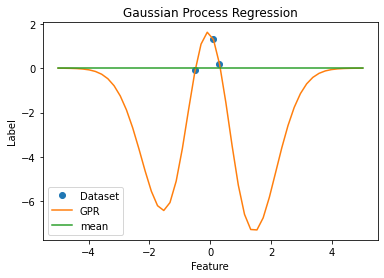

In [71]:
lengthscale = 1.
alpha = solve_posterior_predictive_mean(lengthscale, mean, kernel, X, Y)
print("Weights", alpha)
plt.plot(X[:,0], Y, marker='o', linestyle='none', label='Dataset')
pred = partial(predict_posterior_predictive_mean, lengthscale, mean, kernel, X, alpha)
xs = np.linspace(-5, 5)
y_preds = [pred(np.array([x])) for x in xs]
plt.plot(xs, y_preds, label='GPR'); 
plt.plot(xs, np.zeros(xs.shape[0]), label='mean');
plt.xlabel('Feature'); plt.ylabel('Label')
plt.legend(); plt.title('Gaussian Process Regression')

#### Observation 3: Effect of Lengthscale

1. The lengthscale controls the influence of points in the dataset.
2. Longer lengthscales means that we want our models to have larger influence.

Text(0.5, 1.0, 'Gaussian Process Regression')

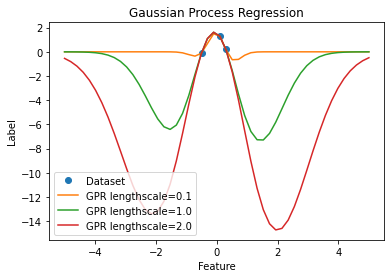

In [72]:
plt.plot(X[:,0], Y, marker='o', linestyle='none', label='Dataset')

for lengthscale in [.1, 1., 2.]:
    alpha = solve_posterior_predictive_mean(lengthscale, mean, kernel, X, Y)
    pred = partial(predict_posterior_predictive_mean, lengthscale, mean, kernel, X, alpha)
    xs = np.linspace(-5, 5)
    y_preds = [pred(np.array([x])) for x in xs]
    plt.plot(xs, y_preds, label=f'GPR lengthscale={lengthscale}'); 
plt.xlabel('Feature'); plt.ylabel('Label')
plt.legend(); plt.title('Gaussian Process Regression')

#### Observation 4: A fitted GP is a GP